# Optimal Non-Hierarchical Clustering

In [ ]:
%%capture
%run ./HDBSCAN_algorithm.ipynb

While the HDBSCAN* hierarchy provides a comprehensive view of density structure at all possible scales, practical applications typically require a single, flat partition of the data.

A naive approach to flattening the hierarchy would be to cut the dendrogram at a specific horizontal level (a global $\epsilon$ threshold). However, this replicates the limitations of standard DBSCAN: it assumes all clusters exist at the same density. In reality, valid clusters often vary significantly in density (some are tight and dense, while others are sparse and diffuse).

To resolve this, HDBSCAN* introduces an optimization algorithm based on **Cluster Stability**. Instead of a global cut, we treat the hierarchy as a solution space and select a combination of non-overlapping clusters that persist longest across ranges of density.

## Cluster Stability

To quantify stability, it is mathematically convenient to invert the distance metric. We define the density level $\lambda$ as the inverse of the distance scale $\epsilon$:

$$\lambda = \frac{1}{\epsilon}$$

This means that $\lambda = 0$ corresponds to infinite distance (the entire dataset is connected), and as $\lambda \to \infty$, the distance threshold shrinks to zero (points become isolated).

We define the stability of a cluster based on its **Relative Excess of Mass**. Conceptually, a cluster is more stable if it contains many points that "survive" a large range of $\lambda$ values before falling out of the cluster.

For a specific cluster $C_i$:
* $\lambda_{min}(C_i)$ is the density threshold where the cluster is constructed (or split from a parent).
* For every object $x_j \in C_i$, $\lambda_{max}(x_j, C_i)$ is the density threshold at which that specific object ceases to belong to $C_i$ (either because the cluster splits or the object becomes noise).

The stability $S(C_i)$ is calculated as the sum of the density ranges (persistence) of all its member objects:

$$S(C_i) = \sum_{x_j \in C_i} (\lambda_{max}(x_j, C_i) - \lambda_{min}(C_i)) = \sum_{x_j \in C_i} \left( \frac{1}{\epsilon_{min}(x_j, C_i)} - \frac{1}{\epsilon_{max}(C_i)} \right)$$

## Optimization Problem

The goal is to extract a collection of clusters that maximizes total stability. Let $\{C_2, \dots, C_k\}$ be the set of all clusters in the hierarchy (excluding the root). We introduce a binary vector $\delta$, where $\delta_i = 1$ if cluster $C_i$ is selected for the final partition, and $\delta_i = 0$ otherwise.

The problem is formulated as maximizing the objective function $J$:

$$\text{maximize } J = \sum_{i=2}^{k} \delta_i S(C_i)$$

For every path from a leaf node to the root, exactly one cluster can be selected (i.e., $\delta_i = 1$). This constraint ensures that the resulting clusters are non-overlapping; a cluster cannot be selected if its parent or any of its descendants are also selected.

To solve this efficiently, we use a dynamic programming approach that traverses the cluster tree bottom-up. We calculate a value $\hat{S}(C_i)$, which represents the maximum stability achievable by the subtree rooted at $C_i$. This method is represented in *Algorithm 3*:

> **ALGORITHM 3**

> 1. Initialize $\delta_{2}= \dots =\delta_{k}=1$, and, for all leaf nodes, set $\hat{S}(C_{h})=S(C_{h})$.
> 2. Starting from the deepest levels, do bottom-up (except for the root):
>    1. If $S(C_{i})<\hat{S}(C_{i_{i}})+\hat{S}(C_{i_{r}})$, set $S(C_{i})=S(C_{i_{l}})+S(C_{i_{r}})$ and set $\delta_{i}=0.$
>    2. Else: set $\hat{S}(C_{i}) = S(C_{i})$ and set $\delta_{(\cdot)}=0$ for all clusters in $C_{i}$ subtrees.


The logic compares the stability of the current cluster against the combined stability of its children:

1.  **If $C_i$ is a leaf node:**
    $$\hat{S}(C_i) = S(C_i)$$

2.  **If $C_i$ is an internal node:**
    We compare the stability of keeping $C_i$ versus the best solution found in its left child ($C_{i_l}$) and right child ($C_{i_r}$):
    $$\hat{S}(C_i) = \max \{ S(C_i), \hat{S}(C_{i_l}) + \hat{S}(C_{i_r}) \}$$

**Cluster Selection:**
* If $S(C_i) > \hat{S}(C_{i_l}) + \hat{S}(C_{i_r})$, then the cluster $C_i$ is more stable than its sub-parts. We select it (potentially tentatively) and "discard" its descendants from the solution ($\delta_{descendants} = 0$).
* Otherwise, the substructure provided by the children is more stable. We set the propagated stability $\hat{S}(C_i)$ to the children's sum and do not select $C_i$ ($\delta_i = 0$).

After reaching the root, the final selection is obtained by traversing top-down and collecting the highest-level clusters that were not discarded. This provides the optimal flat partition in $O(n)$ time complexity.

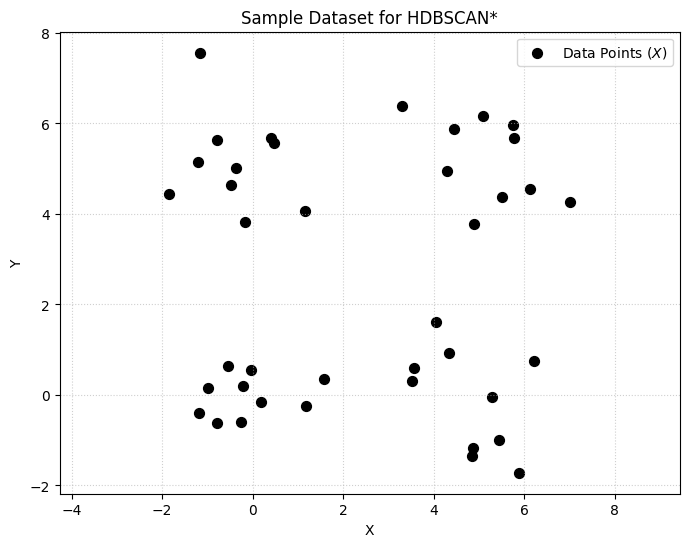

In [3]:
# Generate 4 clusters (2D) for testing
c1  = np.random.randn(10, 2) + np.array([0, 0])
c2  = np.random.randn(10, 2) + np.array([5, 5])
c3  = np.random.randn(10, 2) + np.array([0, 5])
c4  = np.random.randn(10, 2) + np.array([5, 0])
X   = np.vstack((c1, c2, c3, c4))

m_pts = 4

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='black', marker='o', s=50, label='Data Points ($X$)')
plt.title('Sample Dataset for HDBSCAN*')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper right')
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [4]:
hierarchy = hdbscan(X, m_pts, evolution=False, verbose=False)

In [ ]:
def optimal_clustering(hierarchy):
    """
    Extracts the optimal flat clustering from a hierarchy list
    based on the HDBSCAN* stability optimization.
    """
    
    # 1. Preprocess: Convert scales to lambdas (density = 1/distance)
    #    Handle inf by setting lambda to 0
    lambdas = []
    for level in hierarchy:
        scale = level['scale']
        if scale == np.inf:
            lambdas.append(0.0)
        else:
            lambdas.append(1.0 / scale)
    
    n_points = len(hierarchy[0]['labels'])
    
    # 2. Build the Cluster Tree and Calculate Stability
    #    We track every unique cluster label found in the hierarchy.
    #    Structure: {label: {'parent': x, 'children': [], 'stability': 0.0, 'birth': lambda}}
    clusters = {}
    
    # Initialize with the root level (assuming single cluster '1' at index 0)
    root_label = hierarchy[0]['labels'][0]
    clusters[root_label] = {
        'parent': None, 
        'children': set(), 
        'stability': 0.0, 
        'birth': lambdas[0]
    }
    
    # Iterate through the hierarchy to build tree and sum stability
    for i in range(1, len(hierarchy)):
        curr_labels = hierarchy[i]['labels']
        prev_labels = hierarchy[i-1]['labels']
        curr_lambda = lambdas[i]
        
        # Determine parent/child relationships for new clusters appearing at this level
        for label in np.unique(curr_labels):
            if label == 0: continue # Skip noise
            
            if label not in clusters:
                # Find the parent (the label of these points in the previous level)
                # We look at the mask of points that are currently 'label'
                mask = (curr_labels == label)
                parent_candidates = prev_labels[mask]
                
                # In a strict hierarchy, they should all come from the same parent
                # (We take the mode to be safe against edge case noise)
                parent = int(np.bincount(parent_candidates[parent_candidates!=0]).argmax())
                
                clusters[label] = {
                    'parent': parent,
                    'children': set(),
                    'stability': 0.0,
                    'birth': curr_lambda
                }
                
                if parent in clusters:
                    clusters[parent]['children'].add(label)

    # Calculate Stability: Sum of (death_lambda - birth_lambda) for every point in the cluster
    for p in range(n_points):
        # Trace this point's path through the hierarchy
        for i in range(len(hierarchy)):
            label = hierarchy[i]['labels'][p]
            if label == 0: continue
            
            # The point contributes to this cluster's stability
            # Contribution is the duration of the *current level*
            # We approximate this by summing the delta between levels
            
            # Find when this segment ends for the point
            if i + 1 < len(hierarchy):
                next_lambda = lambdas[i+1]
                duration = next_lambda - lambdas[i]
                if label in clusters:
                    clusters[label]['stability'] += duration
            # Note: A more precise calculation uses exact birth/death of the cluster 
            # node, but summing level durations is mathematically equivalent 
            # for the discrete levels provided.

    # 3. Optimization (Dynamic Programming)
    #    Compute S_hat (propagated stability) bottom-up
    
    # We need a list of labels sorted by tree depth (or just ensure children processed first)
    # A simple way is to sort by birth lambda descending (deepest first)
    sorted_labels = sorted(clusters.keys(), key=lambda x: clusters[x]['birth'], reverse=True)
    
    s_hat = {} # Propagated stability
    selected = {} # Whether this cluster is selected
    
    for label in sorted_labels:
        cluster = clusters[label]
        my_stability = cluster['stability']
        
        # Calculate sum of children's S_hat
        children_stability = sum(s_hat.get(child, 0) for child in cluster['children'])
        
        if my_stability > children_stability:
            # This cluster is more stable than its parts
            s_hat[label] = my_stability
            selected[label] = True
            # Deselect children (conceptually)
        else:
            # The parts are better
            s_hat[label] = children_stability
            selected[label] = False
            
    # 4. Extract Final Labels
    #    Traverse top-down to find the highest selected clusters
    final_labels = np.zeros(n_points, dtype=int)
    
    for p in range(n_points):
        # Trace path again
        assigned = False
        # Look for the specific cluster assignments in the hierarchy
        # We start from the finest grain (bottom) or root? 
        # Easier: check the deepest cluster in the point's path that is 'selected'
        # AND has no selected ancestors (optimization ensures non-overlapping)
        
        # Actually, the standard extraction:
        # If root is selected, everyone is root.
        # If root is NOT selected, check children.
        
        # Let's verify the path of the point against selected nodes
        # We walk down from root. If a node is selected, assign and stop.
        # If not, go to the child containing this point.
        
        curr = root_label # Start at root (usually 1)
        
        while True:
            if selected.get(curr, False):
                final_labels[p] = curr
                break
            
            # Find which child this point belongs to
            # We look at the hierarchy levels where this child exists
            found_child = False
            for child in clusters[curr]['children']:
                # Is the point in this child? 
                # Check the hierarchy level where the child was born
                # (This is a simplified lookup, usually we assume strict tree)
                child_birth_idx = -1
                for idx, val in enumerate(lambdas):
                    if val == clusters[child]['birth']:
                        child_birth_idx = idx
                        break
                
                if child_birth_idx != -1 and hierarchy[child_birth_idx]['labels'][p] == child:
                    curr = child
                    found_child = True
                    break
            
            if not found_child:
                # Point falls out of the tree here (becomes noise relative to the extraction)
                final_labels[p] = 0
                break
                
    return final_labels

# --- Usage Example with your Data ---

# Recreating your hierarchy object structure
# (assuming np is imported and the list provided in prompt is assigned to `data`)
hierarchy_data = [
    {'scale': np.inf, 'n_clusters': 1, 'labels': np.array([1]*40)}, 
    {'scale': 2.9755248247368167, 'labels': np.array([2]*10 + [3]*10 + [2]*10 + [3]*10), 'n_clusters': 2},
    # ... (include the full list from your prompt here) ...
]
# Note: For the code to run strictly on the prompt text, 
# you would paste the full list into hierarchy_data.

# Assuming 'hierarchy_object' contains your provided list:
# flat_labels = optimal_clustering(hierarchy_object)
# print("Optimal Labels:", flat_labels)